In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss, precision_recall_curve, roc_curve, confusion_matrix

from scipy.sparse import hstack

import seaborn as sns
import itertools
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [3]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [5]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификаторы для каждой модели и запустим кросс-валидацию

In [6]:
classifier_logreg = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

classifier_forest = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

classifier_boosting = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

Добавим функцию для кросс-валидации

In [7]:
def cross_validation_func(classifier):
    #запустим кросс-валидацию
    cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
    cv_score = np.mean(cv_scores)
    cv_score_std = np.std(cv_scores)
    print('CV score is {}+-{}'.format(cv_score, cv_score_std))

    #обучим пайплайн на всем тренировочном датасете
    classifier.fit(X_train, y_train)
    return classifier.predict_proba(X_test)[:, 1]

Запустим кросс-валидацию для каждой из моделей

In [8]:
y_score_logreg = cross_validation_func(classifier_logreg)
y_score_forest = cross_validation_func(classifier_forest)
y_score_boosting = cross_validation_func(classifier_boosting)

CV score is 0.7867401104915408+-0.00852135511666111
CV score is 0.7734501681056019+-0.007171140345435727
CV score is 0.8025125910838183+-0.00707472977074522


Посчитаем precision/recall/f_score

In [9]:
def calc_metrics(y_test, y_score, b=1):
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    return (thresholds[ix], fscore[ix], precision[ix], recall[ix])

Посчитаем метрики

In [10]:
logreg_metrics = calc_metrics(y_test, y_score_logreg)
forest_metrics = calc_metrics(y_test, y_score_forest)
boosting_metrics = calc_metrics(y_test, y_score_boosting)

Сделаем вывод метрик по моделям в виде датафрейма

In [11]:
data = [logreg_metrics, forest_metrics, boosting_metrics]
index = ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier']

df = pd.DataFrame(data, index=index, columns=['Threshold', 'F-score', 'Precision', 'Recall'])

In [12]:
df

,Threshold,F-score,Precision,Recall
LogisticRegression,0.386937,0.730323,0.647431,0.837558
RandomForestClassifier,0.350000,0.718863,0.642669,0.815553
GradientBoostingClassifier,0.394947,0.740248,0.697848,0.788134


Нарисуем roc auc кривую

In [13]:
def roc_auc_curve(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig("ROC.png")
    plt.show()

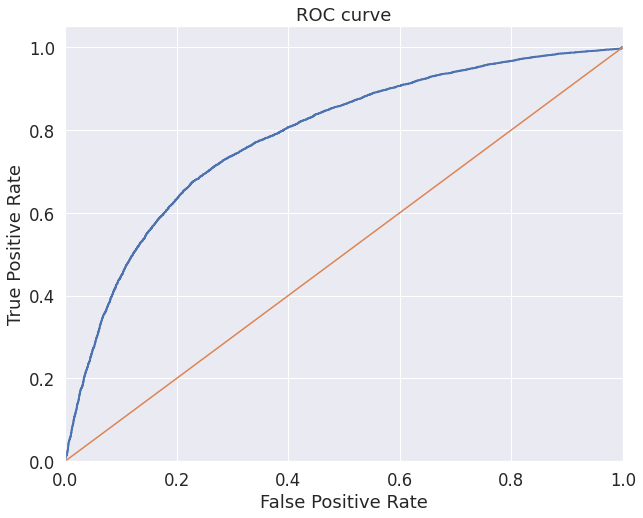

In [14]:
roc_auc_curve(y_test, y_score_logreg)

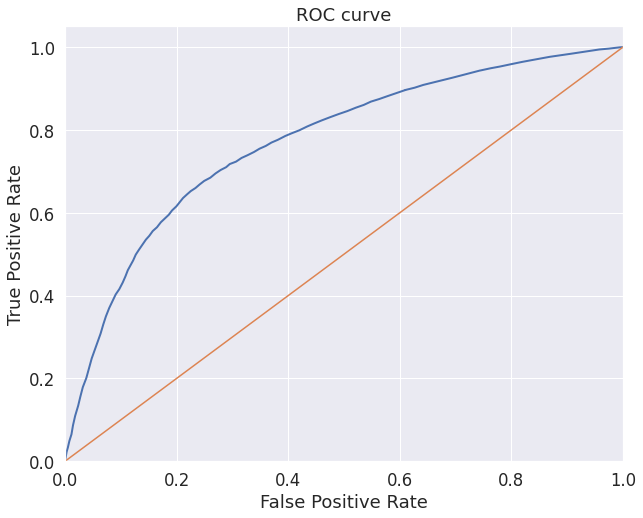

In [15]:
roc_auc_curve(y_test, y_score_forest)

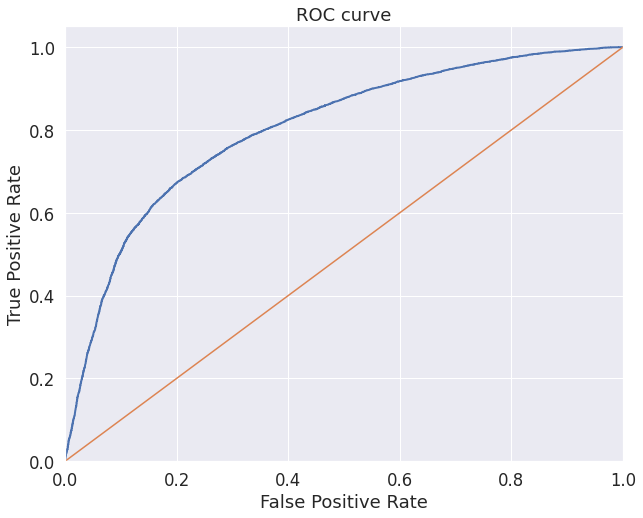

In [16]:
roc_auc_curve(y_test, y_score_boosting)

Рассчитаем roc_auc_score

In [17]:
ras_logreg = roc_auc_score(y_true=y_test, y_score=classifier_logreg.fit(X_train, y_train).predict_proba(X_test)[:,1])

In [18]:
ras_forest = roc_auc_score(y_true=y_test, y_score=classifier_forest.fit(X_train, y_train).predict_proba(X_test)[:,1])

In [19]:
ras_boosting = roc_auc_score(y_true=y_test, y_score=classifier_boosting.fit(X_train, y_train).predict_proba(X_test)[:,1])

Добавим в датафрейм столбес с метрикой ro_auc_score

In [20]:
df['Roc_Auc_Score'] = [ras_logreg, ras_forest, ras_boosting]

In [21]:
df

,Threshold,F-score,Precision,Recall,Roc_Auc_Score
LogisticRegression,0.386937,0.730323,0.647431,0.837558,0.784035
RandomForestClassifier,0.350000,0.718863,0.642669,0.815553,0.771037
GradientBoostingClassifier,0.394947,0.740248,0.697848,0.788134,0.802615


**Кривые roc_auc_curve подходят, когда наблюдения сбалансированы между каждым классом, а precision_recall_curve подходят для несбалансированных наборов данных. Precision и recall не зависят, в отличие от accuracy, от соотношения классов и потому применимы в условиях несбалансированных выборок**

**Самые высокие показатели у модели GradientBostingClassifier**

Посомтрим на матрицу ошибок

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
def make_confusion_matrix(y_score, threshold):
    font = {'size' : 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, y_score>threshold)
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                          title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()

Построим матрицы для каждой модели

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


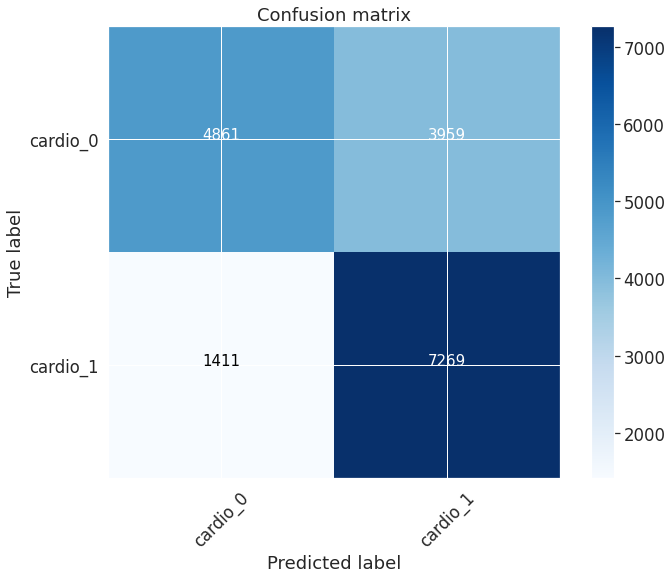

In [24]:
make_confusion_matrix(y_score_logreg, logreg_metrics[0])

Confusion matrix, without normalization
[[4991 3829]
 [1663 7017]]


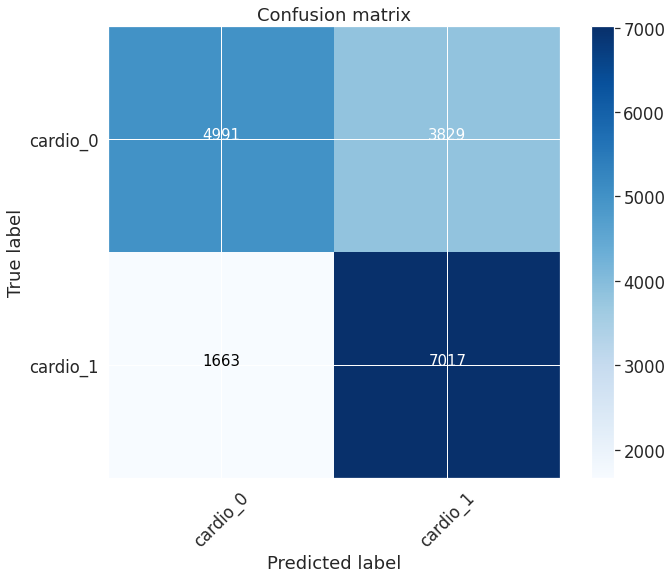

In [25]:
make_confusion_matrix(y_score_forest, forest_metrics[0])

Confusion matrix, without normalization
[[5858 2962]
 [1840 6840]]


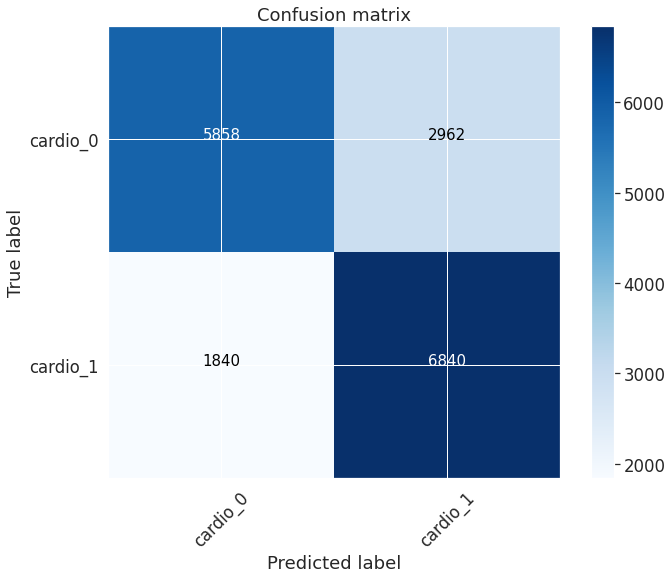

In [26]:
make_confusion_matrix(y_score_boosting, boosting_metrics[0])